# Import libraries

In [1]:
#!pip install numba

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We will use polara framework
from polara import get_movielens_data
from polara.preprocessing.dataframes import leave_one_out, reindex

# sparce matrix packages
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds


import warnings
from functools import wraps
from itertools import takewhile, count, islice


from scipy.sparse.linalg import svds
from scipy.sparse import diags, SparseEfficiencyWarning
from scipy.linalg import solve_banded

from polara.lib.sparse import arrange_indices
from polara.lib.tensor import ttm3d_seq, ttm3d_par
try:
    from sklearn.utils.extmath import randomized_svd
except ImportError:
    randomized_svd = None
    
    
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED

from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.evaluation.python_evaluation import (
    rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, recall_at_k, get_top_k_items
)

import torch
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42);


# Define useful functions

In [3]:
def transform_indices(data, users, items):
    data_index = {}
    for entity, field in zip(['users', 'items'], [users, items]):
        idx, idx_map = to_numeric_id(data, field)
        data_index[entity] = idx_map
        data.loc[:, field] = idx
    return data, data_index

def to_numeric_id(data, field):
    idx_data = data[field].astype("category")
    idx = idx_data.cat.codes
    idx_map = idx_data.cat.categories.rename(field)
    return idx, idx_map


class SeqTFError(Exception):
    pass

def initialize_columnwise_orthonormal(dims, random_state=None):
    if random_state is None:
        random_state = np.random
    u = random_state.rand(*dims)
    u = np.linalg.qr(u, mode='reduced')[0]
    return u


def core_growth_callback(growth_tol):
    def check_core_growth(step, core_norm, factors):
        g_growth = (core_norm - check_core_growth.core_norm) / core_norm
        check_core_growth.core_norm = core_norm
        print(f'growth of the core: {g_growth}')
        if g_growth < growth_tol:
            print(f'Core is no longer growing. Norm of the core: {core_norm}.')
            raise StopIteration
    check_core_growth.core_norm = 0
    return check_core_growth


def sa_hooi(
        idx, val, shape, mlrank, attention_matrix, scaling_weights,
        max_iters = 10,
        parallel_ttm = False,
        growth_tol = 0.001,
        randomized=True,
        seed = None,
        iter_callback=None,
    ):
    
    assert valid_mlrank(mlrank)
    n_users, n_items, n_positions = shape
    r0, r1, r2 = mlrank
    
    tensor_data = idx, val, shape
    if not isinstance(parallel_ttm, (list, tuple)):
        parallel_ttm = [parallel_ttm] * len(shape)

    assert len(shape) == len(parallel_ttm)

    index_data = arrange_indices(idx, parallel_ttm)
    ttm = [ttm3d_par if par else ttm3d_seq for par in parallel_ttm]

    random_state = np.random if seed is None else np.random.RandomState(seed)
    u1 = initialize_columnwise_orthonormal((n_items, r1), random_state)
    uw = u1 * scaling_weights[:, np.newaxis]
    u2 = initialize_columnwise_orthonormal((n_positions, r2), random_state)
    ua = attention_matrix.dot(u2)

    if randomized:
        svd = randomized_svd
        svd_config = lambda rank: dict(n_components=rank, random_state=seed)
    else:
        svd = svds
        svd_config = lambda rank: dict(k=rank, return_singular_vectors='u')
    
    if iter_callback is None:
        iter_callback = core_growth_callback(growth_tol)
        
    
    for step in range(max_iters):
        ttm0 = ttm[0](*tensor_data, ua, uw, ((2, 0), (1, 0)), *index_data[0]).reshape(shape[0], r1*r2)
        u0, *_ = svd(ttm0, **svd_config(r0))

        ttm1 = ttm[1](*tensor_data, ua, u0, ((2, 0), (0, 0)), *index_data[1]).reshape(shape[1], r0*r2)
        u1, *_ = svd(ttm1, **svd_config(r1))
        uw = u1 * scaling_weights[:, np.newaxis]
        

        ttm2 = ttm[2](*tensor_data, uw, u0, ((1, 0), (0, 0)), *index_data[2]).reshape(shape[2], r0*r1)
        u2, ss, _ = svd(ttm2, **svd_config(r2))
        ua = attention_matrix.dot(u2)

        factors = (u0, u1, u2)
        try:
            iter_callback(step, np.linalg.norm(ss), factors)
        except StopIteration:
            break
    return factors


def exp_decay(decay_factor, n):
    return np.e**(-(n-1)*decay_factor)

def lin_decay(decay_factor, n):
    return n**(-decay_factor)



def attention_weights(decay_factor, cutoff, max_elements=None, exponential_decay=False, reverse=False):
    if (decay_factor == 0 or cutoff == 0) and (max_elements is None or max_elements <= 0):
        raise SeqTFError('Infinite sequence.')
    decay_function = exp_decay if exponential_decay else lin_decay
    weights = takewhile(lambda x: x>=cutoff, (decay_function(decay_factor, n) for n in count(1, 1)))
    if max_elements is not None:
        weights = islice(weights, max_elements)
    if reverse:
        return list(reversed(list(weights)))
    return list(weights)

def form_attention_matrix(size, decay_factor, cutoff=0, span=0, exponential_decay=False, reverse=False, format='csc', stochastic_axis=None, dtype=None):
    stochastic = stochastic_axis is not None
    span = min(span or np.iinfo('i8').max, size)
    weights = attention_weights(decay_factor, cutoff=cutoff, max_elements=span, exponential_decay=exponential_decay, reverse=reverse)
    diag_values = [np.broadcast_to(w, size) for w in weights]
    matrix = diags(diag_values, offsets=range(0, -len(diag_values), -1), format=format, dtype=dtype)
    if stochastic:
        scalings = matrix.sum(axis=stochastic_axis).A.squeeze()
        if stochastic_axis == 0:
            matrix = matrix.dot(diags(1./scalings))
        else:
            matrix = diags(1./scalings).dot(matrix)
    return matrix.asformat(format)


def generate_banded_form(matrix):
    matrix = matrix.todia()
    bands = matrix.data
    offsets = matrix.offsets
    num_l = (offsets < 0).sum()
    num_u = (offsets > 0).sum()
    return (num_l, num_u), bands[np.argsort(offsets)[::-1], :]


def generate_position_projector(attention_matrix, position_factors):
    shape, bands = generate_banded_form(attention_matrix.T)
    wl = solve_banded(shape, bands, position_factors)
    wr = attention_matrix.dot(position_factors)
    last_position_projector = wr @ wl[-1, :]
    return last_position_projector


def get_scaling_weights(frequencies, scaling=1.0):
    return np.power(frequencies, 0.5*(scaling-1.0))


def valid_mlrank(mlrank):
    prod = np.prod(mlrank)
    return all(prod//r > r for r in mlrank)

def downvote_seen_items(scores, data, data_description):
    userid = data_description['users']
    itemid = data_description['items']
    # get indices of observed data
    user_idx = data[userid].values
    item_idx = data[itemid].values
    # downvote scores at the corresponding positions
    user_idx, _ = pd.factorize(user_idx, sort=True)
    seen_idx_flat = np.ravel_multi_index((user_idx, item_idx), scores.shape)
    np.put(scores, seen_idx_flat, -np.inf)


def topn_recommendations(scores, topn=10):
    recommendations = np.apply_along_axis(topidx, 1, scores, topn)
    return recommendations


def topidx(a, topn):
    parted = np.argpartition(a, -topn)[-topn:]
    return parted[np.argsort(-a[parted])]


def model_evaluate(recommended_items, holdout, holdout_description, topn=10):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    assert recommended_items.shape[0] == len(holdout_items)
    hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    # MRR calculation
    n_test_users = recommended_items.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_users
    # coverage calculation
    n_items = holdout_description['n_items']
    cov = np.unique(recommended_items).size / n_items
    return hr, mrr, cov

from rs_datasets import MovieLens, Rekko

# dowloading and preparing data

In [4]:
rekko = Rekko()
rekko.info()

transactions


,item_id,user_id,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,3336,5177,S,4.430518e+07,4282,0,50
1,481,593316,S,4.430518e+07,2989,0,11
2,4128,262355,S,4.430518e+07,833,0,50



ratings


,user_id,item_id,rating,ts
0,571252,1364,10,4.430517e+07
1,63140,3037,10,4.430514e+07
2,443817,4363,8,4.430514e+07



bookmarks


,user_id,item_id,ts
0,301135,7185,4.430516e+07
1,301135,4083,4.430516e+07
2,301135,10158,4.430516e+07


In [11]:
data = rekko.ratings.sort_values(['user_id', 'ts'], ascending=[True, True])

counts = data.user_id.value_counts()

data = data.loc[data.user_id.isin(counts[counts >= 20].index)]
data.shape

counts = data.item_id.value_counts()

data = data.loc[data.item_id.isin(counts[counts >= 20].index)]
data.rename(columns = {'user_id':'userid', 'item_id':'movieid', 'ts':'timestamp'}, inplace = True)
# ts_split = data.timestamp.quantile(q=0.95, interpolation='nearest')

# data_train_ = data.loc[data.timestamp < ts_split].drop(columns='timestamp')
# data_test_ = data.loc[(data.timestamp >= ts_split) & (data.userid.isin(data_train.userid.unique()))].drop(columns='timestamp')

# data_train.shape, data_test.shape

In [12]:
mldata = data

In [13]:
#mldata = get_movielens_data(include_time=True)
mldata.head(3)

,userid,movieid,rating,timestamp
395385,552,4290,7,4.196448e+07
363939,552,6209,4,4.213473e+07
336813,552,6397,7,4.229591e+07


## Data splitting

In [14]:
test_timepoint = mldata['timestamp'].quantile(
    q=0.95, interpolation='nearest'
)

test_data_ = mldata.query('timestamp >= @test_timepoint')

train_data_ = mldata.query(
    'userid not in @test_data_.userid.unique() and timestamp < @test_timepoint'
)

#### percentage of numerical values in data

In [15]:
train_data_.shape[0] / np.prod(train_data_.nunique().iloc[:2])

0.020784199216848976

#### Reindex dataset to drop gaps

In [16]:
training, data_index = transform_indices(train_data_.copy(), 'userid', 'movieid')
test_data = reindex(test_data_, data_index['items'])


We sample the last item for each test user.  
As all these users are excluded from the training, and training is additionally filtered by timestamp,
there will be no "recommendation from future" issue - our model is unaware of future correlations.


In [17]:
testset_, holdout_ = leave_one_out(
    test_data, target='timestamp', sample_top=True, random_state=0
)
testset_valid_, holdout_valid_ = leave_one_out(
    testset_, target='timestamp', sample_top=True, random_state=0
)

Let's focus on validation part.

In [18]:
test_users = np.intersect1d(testset_valid_.userid.unique(), holdout_valid_.userid.unique())
testset_valid = testset_valid_.query('userid in @test_users').sort_values('userid')
holdout_valid = holdout_valid_.query('userid in @test_users').sort_values('userid')

In [19]:
assert holdout_valid.set_index('userid')['timestamp'].ge(
    testset_valid
    .groupby('userid')
    ['timestamp'].max()
).all()

## Assigning positional info

In [20]:
n_pos = 200

In [21]:
def assign_positions(s, maxlen=n_pos):
    return np.arange(maxlen-len(s), maxlen)


In [22]:
training_data = (
    training
    .sort_values('timestamp')
    .assign(
        pos = lambda df: df.groupby('userid')['movieid'].transform(assign_positions)
    )
    .sort_values(['userid', 'timestamp'])
    .query('pos>=0')
)

In [23]:
testset_valid = (
    testset_valid
    .sort_values('timestamp')
    .assign(
        pos = lambda df: df.groupby('userid')['movieid'].transform(assign_positions)
    )
    .sort_values(['userid', 'timestamp'])
)

### 1 metric = hit rate (this percent with proper recoms, more or less good 10, top score 15-20), 2 = MRR, 3 = coverage (measure of diversity of recomandations, if low => model generates something popular => useless for the user, we want our recomendations to be diverce = how many unique recoms made on test users/total number of items in catalog, popularity 5%)

# Sequential TF

In [24]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    positions = 'pos',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    n_pos = n_pos
)
data_description

{'users': 'userid',
 'items': 'movieid',
 'feedback': 'rating',
 'positions': 'pos',
 'n_users': 1688,
 'n_items': 1266,
 'n_pos': 200}

### computing tucker docmositions

In [25]:
def seqtf_model_build(config, data, data_description):
    userid = data_description["users"]
    itemid = data_description["items"]
    positions = data_description["positions"]

    n_users = data_description["n_users"]
    n_items = data_description["n_items"]
    max_pos = data_description["n_pos"]
    shape = (n_users, n_items, max_pos)

    #positional attention
    attention_matrix = form_attention_matrix(
        size = data_description["n_pos"],
        exponential_decay = config["exponential_decay"],
        #rule = linear decay
        decay_factor = config["attention_decay"],
        format = 'csr'
    )

    # popularity based weighting - to 
    # combat with low diversity rating
    # reweight values in tensors - not binary
    # inversely proportional to the popularity of items
    # more sensitive to less popular items
    # promote less popular items in recoms
    
    # POpularity based scaling
    item_popularity = (
        data[itemid]
        .value_counts(sort=False)
        .reindex(range(n_items))
        .fillna(1)
        .values
    )
    
    scaling_weights = get_scaling_weights(item_popularity, scaling=config["scaling"])
    idx = data[[userid, itemid, positions]].values
    val = np.ones(idx.shape[0], dtype='f8')

    user_factors, item_factors, feedback_factors = sa_hooi(
        # hooi takes into account information about initial tensor
        idx, val, shape, config["mlrank"],
        # attention matrix
        attention_matrix = attention_matrix,
        # popularity scaling
        scaling_weights = scaling_weights,
        max_iters = config["num_iters"],
        parallel_ttm = False,
        
        # randomized svd instead of standart
        randomized = config["randomized"],
        growth_tol = config["growth_tol"],
        seed = config["seed"],
        # max hit rate is goal but here we minimize squred error, so idea
        # compute hit rate after each iteration, and if subsequent iterations 
        # do not improve hit rate we stop
        
        # typically for hit rate requires lower iterations
        iter_callback = config["iter_callback"],
    )
    return user_factors, item_factors, feedback_factors, attention_matrix


In [26]:
config = {
    #popularity scaling. 1 is factorization without any reweighting
    # (no reweighting)
    "scaling": 1,
    
    #multilinear rank is smaller tnan 50 that is used for svd
    "mlrank": (30, 30, 5),
    "n_pos": n_pos,
    "num_iters": 20,
    "attention_decay": 1,
    "randomized": True,
    "growth_tol": 1e-4,
    "seed": 42,
    "iter_callback":None,
    "exponential_decay":False
}

In [27]:
tf_params = seqtf_model_build(config, training_data, data_description)

growth of the core: 1.0
growth of the core: 0.33823003700122517
growth of the core: 0.0951636768292234
growth of the core: 0.033994711263465476
growth of the core: 0.014331966433324763
growth of the core: 0.007569007046418173
growth of the core: 0.0042314023283941665
growth of the core: 0.0023096470620106407
growth of the core: 0.0014888727840097684
growth of the core: 0.0011632392696079707
growth of the core: 0.0008722714267248492
growth of the core: 0.0008880815686604362
growth of the core: 0.00038452682754106014
growth of the core: 0.00044491984067621083
growth of the core: 0.00011360364152758712
growth of the core: 0.00040389936933123166
growth of the core: 9.588350602061907e-05
Core is no longer growing. Norm of the core: 23.29558588182362.


In [28]:
def tf_scoring(params, data, data_description):
    user_factors, item_factors, pos_factors, attention_matrix = params
    last_position_projector = generate_position_projector(attention_matrix, pos_factors)

    userid = data_description["users"]
    itemid = data_description["items"]
    posid = data_description["positions"]

    test_data = data.sort_values([userid, posid])
    useridx = test_data[userid].values
    itemidx = test_data[itemid].values
    indptr, = np.where(np.diff(useridx, prepend=0, append=1))
    scores = user_scoring(indptr, itemidx, item_factors, last_position_projector)
    return scores

def user_scoring(indptr, indices, item_factors, last_position_projector):
    sequences = np.array_split(indices, indptr[1:-1])
    n_items = item_factors.shape[0]
    scores = np.zeros((len(sequences), n_items))
    for u, seq in enumerate(sequences):
        scores[u] = sequences_score(seq, item_factors, last_position_projector)
    return scores

def sequences_score(seq, item_factors, last_position_projector):
    n_pos = len(last_position_projector)
    user_profile = item_factors[seq[-(n_pos-1):], :]
    n_items = user_profile.shape[0]
    
    # scores calculation from the slide
    scores = item_factors @ (user_profile.T @ last_position_projector[-(n_items+1):-1])
    return scores

In [29]:
tf_scores = tf_scoring(tf_params, testset_valid, data_description)

/Users/sergeypetrakov/opt/miniconda3/lib/python3.8/site-packages/scipy/sparse/coo.py:431: SparseEfficiencyWarning: Constructing a DIA matrix with 200 diagonals is inefficient
  warn("Constructing a DIA matrix with %d diagonals "


In [30]:
tf_scores.shape

(459, 1266)

In [31]:
downvote_seen_items(tf_scores, testset_valid, data_description)

In [32]:
tf_recs = topn_recommendations(tf_scores, topn=10)
model_evaluate(tf_recs, holdout_valid, data_description)

(0.06535947712418301, 0.028100252446657672, 0.14139020537124802)

# Addition experiment

## different scalings

In [33]:
scalings = [-1, 0 , 1, 2, 3]
results_for_scaling = []

for scaling in scalings:
    config = {
        #popularity scaling. 1 is factorization without any reweighting
        # (no reweighting)
        "scaling": scaling,

        #multilinear rank is smaller tnan 50 that is used for svd
        "mlrank": (30, 30, 5),
        "n_pos": n_pos,
        "num_iters": 20,
        "attention_decay": 1,
        "randomized": True,
        "growth_tol": 1e-4,
        "seed": 42,
        "iter_callback":None,
        "exponential_decay":False
    }
    
    print("#"*20)
    print("scaling = {}".format(scaling))
    print("#"*20)
    tf_params = seqtf_model_build(config, training_data, data_description)
    tf_scores = tf_scoring(tf_params, testset_valid, data_description)
    downvote_seen_items(tf_scores, testset_valid, data_description)
    tf_recs = topn_recommendations(tf_scores, topn=10)
    hit_rate, mrr, coverage = np.round(model_evaluate(tf_recs, holdout_valid, data_description), 4)
    print("hit_rate = {}, mrr = {}, coverage = {}".format(hit_rate, mrr, coverage))
    results_for_scaling.append((hit_rate, mrr, coverage))

####################
scaling = -1
####################
growth of the core: 1.0
growth of the core: 0.21308923547311084
growth of the core: 0.057995976164510306
growth of the core: 0.02442437772083491
growth of the core: 0.013944497695376295
growth of the core: 0.008355533703926032
growth of the core: 0.005137134300232523
growth of the core: 0.0032588085394600294
growth of the core: 0.002158331029087518
growth of the core: 0.0014767687646945688
growth of the core: 0.0011157374385206088
growth of the core: 0.0008824492123573194
growth of the core: 0.0007888536451802798
growth of the core: 0.0007343531901060479
growth of the core: 0.000697973602465715
growth of the core: 0.0007097227658226405
growth of the core: 0.0006719316751380249
growth of the core: 0.0006925788070209565
growth of the core: 0.0006309076231860295
growth of the core: 0.0007126454284595485
hit_rate = 0.0937, mrr = 0.0385, coverage = 0.3381
####################
scaling = 0
####################
growth of the core: 1.0
grow

In [34]:
scalings = [-1, 0 , 1, 2, 3]
results_for_scaling = []

for scaling in scalings:
    config = {
        #popularity scaling. 1 is factorization without any reweighting
        # (no reweighting)
        "scaling": scaling,

        #multilinear rank is smaller tnan 50 that is used for svd
        "mlrank": (30, 30, 5),
        "n_pos": n_pos,
        "num_iters": 20,
        "attention_decay": 1,
        "randomized": True,
        "growth_tol": 1e-4,
        "seed": 42,
        "iter_callback":None,
        "exponential_decay":False
    }
    
    print("#"*20)
    print("scaling = {}".format(scaling))
    print("#"*20)
    tf_params = seqtf_model_build(config, training_data, data_description)
    tf_scores = tf_scoring(tf_params, testset_valid, data_description)
    downvote_seen_items(tf_scores, testset_valid, data_description)
    tf_recs = topn_recommendations(tf_scores, topn=10)
    hit_rate, mrr, coverage = np.round(model_evaluate(tf_recs, holdout_valid, data_description), 4)
    print("hit_rate = {}, mrr = {}, coverage = {}".format(hit_rate, mrr, coverage))
    results_for_scaling.append((hit_rate, mrr, coverage))

####################
scaling = -1
####################
growth of the core: 1.0
growth of the core: 0.21308923547311084
growth of the core: 0.057995976164510306
growth of the core: 0.02442437772083491
growth of the core: 0.013944497695376295
growth of the core: 0.008355533703926032
growth of the core: 0.005137134300232523
growth of the core: 0.0032588085394600294
growth of the core: 0.002158331029087518
growth of the core: 0.0014767687646945688
growth of the core: 0.0011157374385206088
growth of the core: 0.0008824492123573194
growth of the core: 0.0007888536451802798
growth of the core: 0.0007343531901060479
growth of the core: 0.000697973602465715
growth of the core: 0.0007097227658226405
growth of the core: 0.0006719316751380249
growth of the core: 0.0006925788070209565
growth of the core: 0.0006309076231860295
growth of the core: 0.0007126454284595485
hit_rate = 0.0937, mrr = 0.0385, coverage = 0.3381
####################
scaling = 0
####################
growth of the core: 1.0
grow

In [35]:
svd_random_inits = [True, False]
results_svd_init = []

for svd_random_init in svd_random_inits:
    config = {
        #popularity scaling. 1 is factorization without any reweighting
        # (no reweighting)
        "scaling": 1.0,

        #multilinear rank is smaller tnan 50 that is used for svd
        "mlrank": (30, 30, 5),
        "n_pos": n_pos,
        "num_iters": 20,
        "attention_decay": 1,
        "randomized": svd_random_init,
        "growth_tol": 1e-4,
        "seed": 42,
        "iter_callback":None,
        "exponential_decay":False
    }
    
    print("#"*20)
    print("svd_random_init = {}".format(svd_random_init))
    print("#"*20)
    tf_params = seqtf_model_build(config, training_data, data_description)
    tf_scores = tf_scoring(tf_params, testset_valid, data_description)
    downvote_seen_items(tf_scores, testset_valid, data_description)
    tf_recs = topn_recommendations(tf_scores, topn=10)
    hit_rate, mrr, coverage = np.round(model_evaluate(tf_recs, holdout_valid, data_description), 4)
    print("hit_rate = {}, mrr = {}, coverage = {}".format(hit_rate, mrr, coverage))
    results_svd_init.append((hit_rate, mrr, coverage))

####################
svd_random_init = True
####################
growth of the core: 1.0
growth of the core: 0.33823003700122517
growth of the core: 0.0951636768292234
growth of the core: 0.033994711263465476
growth of the core: 0.014331966433324763
growth of the core: 0.007569007046418173
growth of the core: 0.0042314023283941665
growth of the core: 0.0023096470620106407
growth of the core: 0.0014888727840097684
growth of the core: 0.0011632392696079707
growth of the core: 0.0008722714267248492
growth of the core: 0.0008880815686604362
growth of the core: 0.00038452682754106014
growth of the core: 0.00044491984067621083
growth of the core: 0.00011360364152758712
growth of the core: 0.00040389936933123166
growth of the core: 9.588350602061907e-05
Core is no longer growing. Norm of the core: 23.29558588182362.
hit_rate = 0.0654, mrr = 0.0281, coverage = 0.1414
####################
svd_random_init = False
####################
growth of the core: 1.0
growth of the core: 0.3380001000407630

/Users/sergeypetrakov/opt/miniconda3/lib/python3.8/site-packages/scipy/sparse/coo.py:431: SparseEfficiencyWarning: Constructing a DIA matrix with 200 diagonals is inefficient
  warn("Constructing a DIA matrix with %d diagonals "


In [36]:
attention_decays_linear = [0.01, 0.1, 1, 2, 5, 10]
results_linear_decay = []

for attention_decay in attention_decays_linear:
    config = {
        #popularity scaling. 1 is factorization without any reweighting
        # (no reweighting)
        "scaling": 1.0,

        #multilinear rank is smaller tnan 50 that is used for svd
        "mlrank": (30, 30, 5),
        "n_pos": n_pos,
        "num_iters": 20,
        "attention_decay": attention_decay,
        "randomized": svd_random_init,
        "growth_tol": 1e-4,
        "seed": 42,
        "iter_callback":None,
        "exponential_decay":False
    }
    
    print("#"*20)
    print("Linear decay with attention = {}".format(attention_decay))
    print("#"*20)
    tf_params = seqtf_model_build(config, training_data, data_description)
    tf_scores = tf_scoring(tf_params, testset_valid, data_description)
    downvote_seen_items(tf_scores, testset_valid, data_description)
    tf_recs = topn_recommendations(tf_scores, topn=10)
    hit_rate, mrr, coverage = np.round(model_evaluate(tf_recs, holdout_valid, data_description), 4)
    print("hit_rate = {}, mrr = {}, coverage = {}".format(hit_rate, mrr, coverage))
    results_linear_decay.append((hit_rate, mrr, coverage))

####################
Linear decay with attention = 0.01
####################
growth of the core: 1.0
growth of the core: 0.2777198284863232
growth of the core: 0.05775558065467085
growth of the core: 0.02325874761094859
growth of the core: 0.013246119506756585
growth of the core: 0.008834802797662926
growth of the core: 0.0064505545119211746
growth of the core: 0.005008309817085214
growth of the core: 0.004009866330216703
growth of the core: 0.0032297401416183434
growth of the core: 0.0025920188385385335
growth of the core: 0.002075088308828187
growth of the core: 0.0016654873097138002
growth of the core: 0.0013466602561428692
growth of the core: 0.0011004806362847877
growth of the core: 0.0009102465317587654
growth of the core: 0.0007621755194515059
growth of the core: 0.0006455953482403534
growth of the core: 0.0005525259909768859
growth of the core: 0.0004771070875408676
hit_rate = 0.0153, mrr = 0.0077, coverage = 0.1256
####################
Linear decay with attention = 0.1
#######

In [37]:
attention_decays_exp = [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10]
results_exp_decay = []

for attention_decay in attention_decays_exp:
    config = {
        #popularity scaling. 1 is factorization without any reweighting
        # (no reweighting)
        "scaling": 1.0,

        #multilinear rank is smaller tnan 50 that is used for svd
        "mlrank": (30, 30, 5),
        "n_pos": n_pos,
        "num_iters": 20,
        "attention_decay": attention_decay,
        "randomized": svd_random_init,
        "growth_tol": 1e-4,
        "seed": 42,
        "iter_callback":None,
        "exponential_decay":True
    }
    
    print("#"*20)
    print("Exponential decay with attention = {}".format(attention_decay))
    print("#"*20)
    tf_params = seqtf_model_build(config, training_data, data_description)
    tf_scores = tf_scoring(tf_params, testset_valid, data_description)
    downvote_seen_items(tf_scores, testset_valid, data_description)
    tf_recs = topn_recommendations(tf_scores, topn=10)
    hit_rate, mrr, coverage = np.round(model_evaluate(tf_recs, holdout_valid, data_description), 4)
    print("hit_rate = {}, mrr = {}, coverage = {}".format(hit_rate, mrr, coverage))
    results_exp_decay.append((hit_rate, mrr, coverage))

####################
Exponential decay with attention = 0.0001
####################
growth of the core: 1.0
growth of the core: 0.2776665839492199
growth of the core: 0.057790403080732786
growth of the core: 0.023260979196506493
growth of the core: 0.013238014270124695
growth of the core: 0.008833273254870414
growth of the core: 0.006453415115169902
growth of the core: 0.005011423458320636
growth of the core: 0.004011859249691762
growth of the core: 0.003230947272936581
growth of the core: 0.0025930703233361992
growth of the core: 0.0020764002646965853
growth of the core: 0.0016672061470615815
growth of the core: 0.0013487484040346778
growth of the core: 0.0011028140404654762
growth of the core: 0.0009126835268475089
growth of the core: 0.000764595116268223
growth of the core: 0.0006479125375921229
growth of the core: 0.0005546924129092128
growth of the core: 0.00047910416647921073
hit_rate = 0.0153, mrr = 0.0075, coverage = 0.1272
####################
Exponential decay with attention 

/Users/sergeypetrakov/opt/miniconda3/lib/python3.8/site-packages/scipy/sparse/coo.py:431: SparseEfficiencyWarning: Constructing a DIA matrix with 150 diagonals is inefficient
  warn("Constructing a DIA matrix with %d diagonals "


growth of the core: 0.40932050982349416
growth of the core: 0.08777794825506317
growth of the core: 0.0349810495855625
growth of the core: 0.018912906195458896
growth of the core: 0.011445309203482558
growth of the core: 0.008859689301774396
growth of the core: 0.0066136153653338844
growth of the core: 0.004741185472114717
growth of the core: 0.0034449499075808166
growth of the core: 0.0024379873448533377
growth of the core: 0.001684399935737139
growth of the core: 0.0012086842025502405
growth of the core: 0.0009657235920642762
growth of the core: 0.0008941184956948813
growth of the core: 0.0009596777770616222
growth of the core: 0.001194353960788717
growth of the core: 0.0017797914220555487
growth of the core: 0.002999469660348107
growth of the core: 0.004053276362492503
hit_rate = 0.0174, mrr = 0.0045, coverage = 0.1351


## Quality metrics and exponential decay

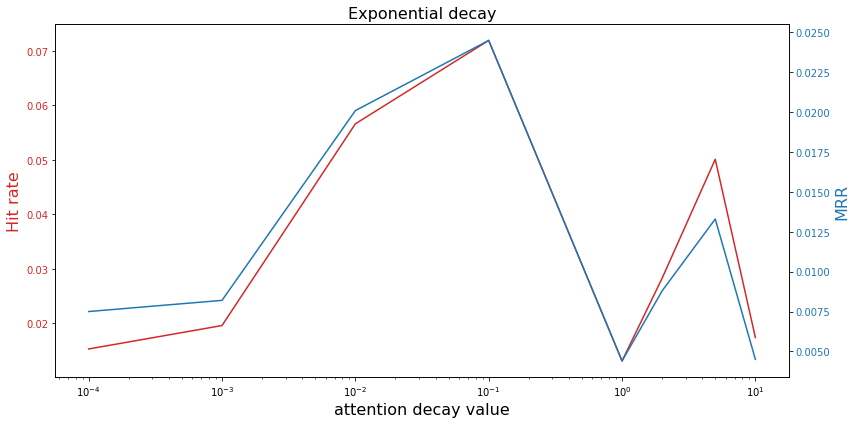

In [38]:
fig, ax1 = plt.subplots(figsize = (12,6))
plt.title("Exponential decay", fontsize = 16)
color = 'tab:red'
ax1.set_xlabel('attention decay value', fontsize = 16)
ax1.set_ylabel('Hit rate', fontsize = 16, color=color)
ax1.set_xscale("log")
ax1.plot(attention_decays_exp, np.array(results_exp_decay)[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('MRR', fontsize = 16, color=color)  # we already handled the x-label with ax1
ax2.plot(attention_decays_exp, np.array(results_exp_decay)[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xscale("log")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

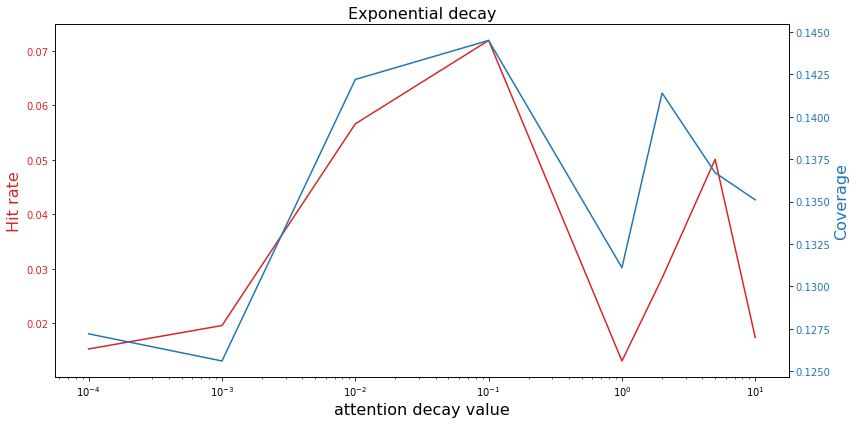

In [39]:
fig, ax1 = plt.subplots(figsize = (12,6))
plt.title("Exponential decay", fontsize = 16)
color = 'tab:red'
ax1.set_xlabel('attention decay value', fontsize = 16)
ax1.set_ylabel('Hit rate', fontsize = 16, color=color)
ax1.set_xscale("log")
ax1.plot(attention_decays_exp, np.array(results_exp_decay)[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Coverage', fontsize = 16, color=color)  # we already handled the x-label with ax1
ax2.plot(attention_decays_exp, np.array(results_exp_decay)[:,2], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xscale("log")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Quality metrics and linear decay

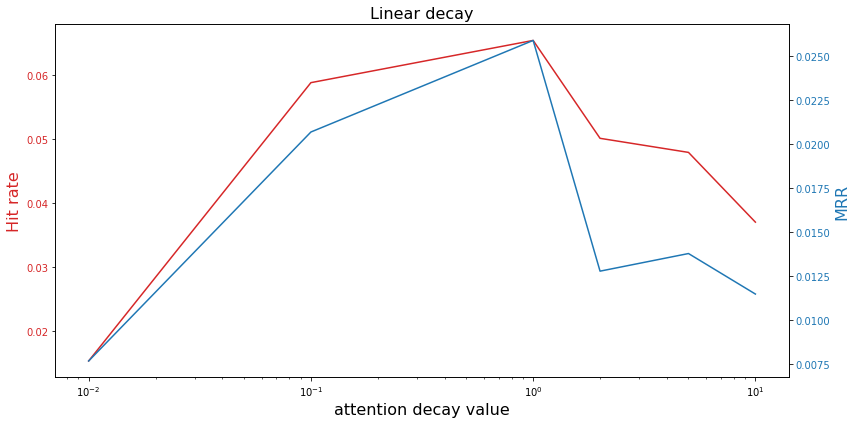

In [40]:
fig, ax1 = plt.subplots(figsize = (12,6))
plt.title("Linear decay", fontsize = 16)
color = 'tab:red'
ax1.set_xlabel('attention decay value', fontsize = 16)
ax1.set_ylabel('Hit rate', fontsize = 16, color=color)
ax1.set_xscale("log")
ax1.plot(attention_decays_linear, np.array(results_linear_decay)[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('MRR', fontsize = 16, color=color)  # we already handled the x-label with ax1
ax2.plot(attention_decays_linear, np.array(results_linear_decay)[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xscale("log")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

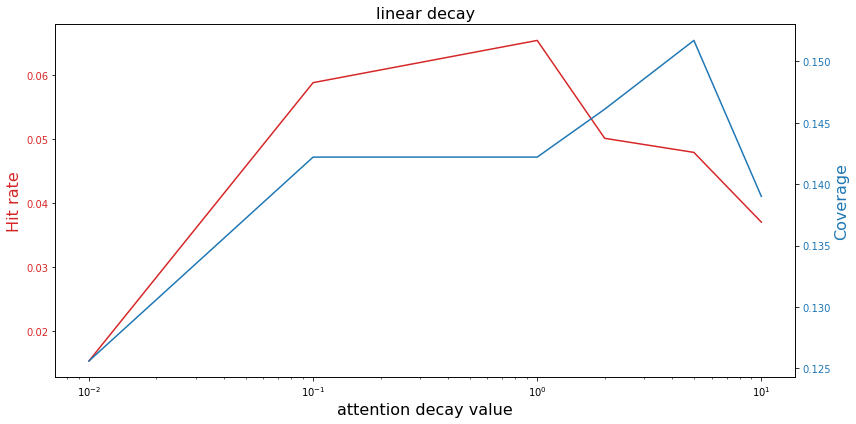

In [41]:
fig, ax1 = plt.subplots(figsize = (12,6))
plt.title("linear decay", fontsize = 16)
color = 'tab:red'
ax1.set_xlabel('attention decay value', fontsize = 16)
ax1.set_ylabel('Hit rate', fontsize = 16, color=color)
ax1.set_xscale("log")
ax1.plot(attention_decays_linear, np.array(results_linear_decay)[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Coverage', fontsize = 16, color=color)  # we already handled the x-label with ax1
ax2.plot(attention_decays_linear, np.array(results_linear_decay)[:,2], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xscale("log")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## SVD random initialization. difference in terms of metrics

In [42]:
(np.array(results_svd_init)[0,:] - np.array(results_svd_init)[1,:]) / np.array(results_svd_init)[0,:] *100

array([ 0.        ,  7.82918149, -0.56577086])

# Scalings

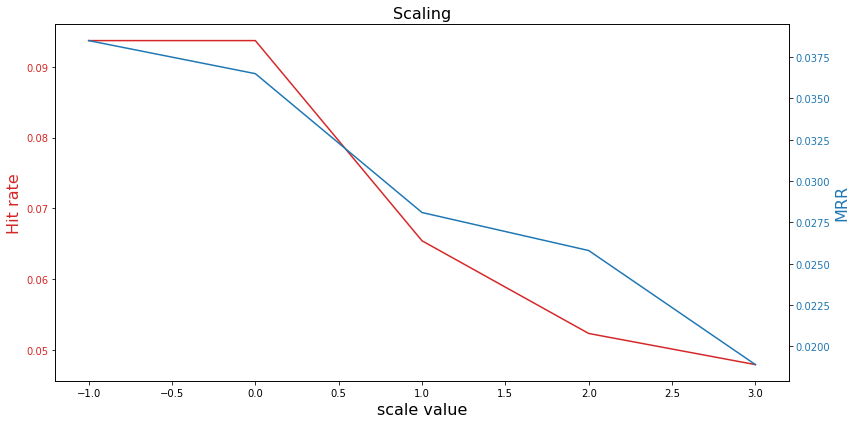

In [43]:
fig, ax1 = plt.subplots(figsize = (12,6))
plt.title("Scaling", fontsize = 16)
color = 'tab:red'
ax1.set_xlabel('scale value', fontsize = 16)
ax1.set_ylabel('Hit rate', fontsize = 16, color=color)

ax1.plot(scalings, np.array(results_for_scaling)[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('MRR', fontsize = 16, color=color)  # we already handled the x-label with ax1
ax2.plot(scalings, np.array(results_for_scaling)[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

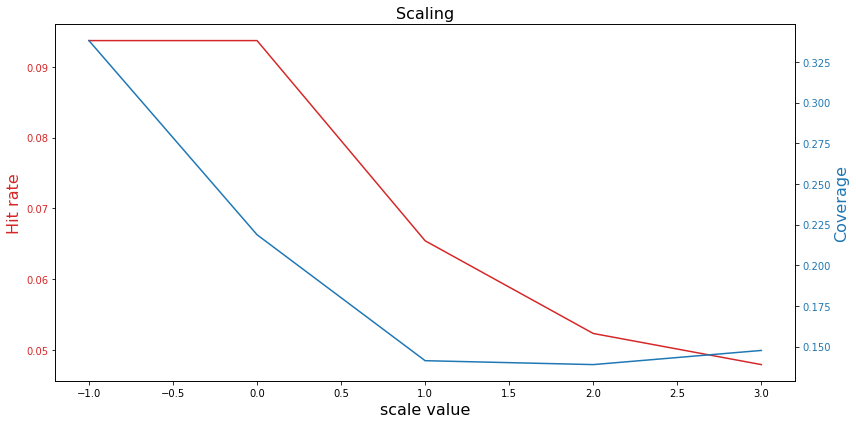

In [44]:
fig, ax1 = plt.subplots(figsize = (12,6))
plt.title("Scaling", fontsize = 16)
color = 'tab:red'
ax1.set_xlabel('scale value', fontsize = 16)
ax1.set_ylabel('Hit rate', fontsize = 16, color=color)

ax1.plot(scalings, np.array(results_for_scaling)[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Coverage', fontsize = 16, color=color)  # we already handled the x-label with ax1
ax2.plot(scalings, np.array(results_for_scaling)[:,2], color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()